# CNN using augmented CIFAR10

Test CNN via build_layers() on augmented CIFAR10. 

In [1]:
import os
import sys
import pathlib
import shutil
from typing import (
    Optional,
    Tuple,
    Generator,
    Any
)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import (
    __version__
)

from keras.datasets import cifar10
from keras.layers import (
    Layer,
    Normalization,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    Dense,
    Flatten,
    Dropout,
    Reshape,
    Activation,
    ReLU,
    LeakyReLU,
)
from keras.models import (
    Model,
    Sequential
)
from keras.layers import (
    Layer
)
from keras.optimizers import (
    Adam
)
from keras.preprocessing.image import (
    ImageDataGenerator
)
from sklearn.model_selection import train_test_split

print("TensorFlow version: {}".format(tf.__version__))
tf.keras.__version__ = __version__
print("Keras version: {}".format(tf.keras.__version__))

2023-11-23 21:13:31.820197: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-23 21:13:31.845736: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 21:13:31.845758: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 21:13:31.845777: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-23 21:13:31.850801: I tensorflow/core/platform/cpu_feature_g

TensorFlow version: 2.14.1
Keras version: 2.14.0


# GPU

In [3]:
MEMORY_LIMIT = 5 * 1024

print("Is there a GPU available: "),
print(tf.config.list_physical_devices("GPU"))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
      
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY_LIMIT)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Is there a GPU available: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs
Virtual devices cannot be modified after being initialized


2023-11-23 21:13:33.074045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 21:13:33.083088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 21:13:33.083365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
path_to_lib: str = str(pathlib.Path(os.path.join(os.getcwd(), "../../../../..")).resolve())
assert isinstance(path_to_lib, str)
sys.path.append(path_to_lib)

# Constant

In [5]:
NUM_CLASSES = 10
input_shape = (32, 32, 3)

# CIFAR-10

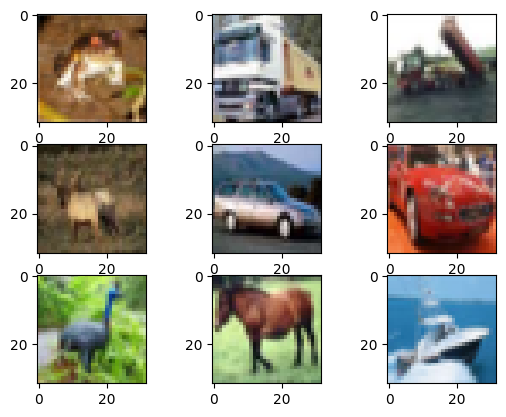

In [6]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()

## Augmented (images, labels) generator

images and labels are batched with ```batch_size```.

In [7]:
imgen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
)

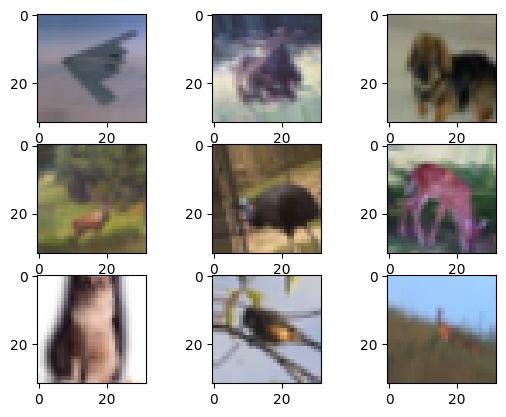

In [8]:
# see example augmentation images
for X_batch, y_batch in imgen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [9]:
x_train=x_train.astype("float32")  
x_test=x_test.astype("float32")

mean=np.mean(x_train)
std=np.std(x_train)

x_test=(x_test-mean)/std
x_train=(x_train-mean)/std
x_train, x_validation, y_train, y_validation = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, shuffle=True
)

x_train.shape

(40000, 32, 32, 3)

# Model

In [10]:
inputs = tf.keras.Input(
    name='image',
    shape=input_shape,
    dtype=tf.float32
) 

x = Conv2D(                                           
    filters=32, 
    kernel_size=(3, 3), 
    strides=(1, 1), 
    padding="same",
    activation='relu', 
    input_shape=input_shape
)(inputs)
x = MaxPooling2D(                                     
    pool_size=(2, 2)
)(x)
x = BatchNormalization()(x)
x = Conv2D(                                           
    filters=64, 
    kernel_size=(3, 3), 
    strides=(1, 1), 
    padding="same",
    activation='relu', 
    input_shape=input_shape
)(x)
x = MaxPooling2D(                                     
    pool_size=(2, 2)
)(x)
x = Dropout(0.20)(x)

x = BatchNormalization()(x)
x = Conv2D(                                           
    filters=128, 
    kernel_size=(3, 3), 
    strides=(1, 1), 
    padding="same",
    activation='relu', 
    input_shape=input_shape
)(x)
x = MaxPooling2D(                                     
    pool_size=(2, 2)
)(x)
x = Dropout(0.20)(x)
x = Flatten()(x)

x = BatchNormalization()(x)
x = Dense(300, activation="relu")(x)
x = Dropout(0.20)(x)
x = BatchNormalization()(x)
x = Dense(200, activation="relu")(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model: Model = Model(
    inputs=inputs, outputs=outputs, name="cifar10"
)

# --------------------------------------------------------------------------------
# Compile model
# --------------------------------------------------------------------------------
learning_rate = 1e-3
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    # https://stackoverflow.com/a/77535234/4281353
    # metrics=["accuracy"]
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)
model.summary()

Model: "cifar10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0   

---
# Training


In [11]:
batch_size = 16
number_of_epochs = 16

In [12]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    patience=30,
    restore_best_weights=True,
    monitor='val_loss'
)

In [13]:
steps_per_epoch = len(y_train) // batch_size
validation_steps = (len(y_validation) // batch_size) - 1

history = model.fit(
    #x=x,
    x=imgen.flow(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        shuffle=True
    ),
    #x=x_train,
    #y=y_train,
    batch_size=batch_size,
    epochs=number_of_epochs,
    verbose=1,
    validation_data=(x_validation, y_validation),
    shuffle=True,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_batch_size=batch_size,
    callbacks=[
        earlystop_callback
    ]
)

Epoch 1/16


2023-11-23 21:13:35.718211: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incifar10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-23 21:13:35.871545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-23 21:13:35.935307: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-23 21:13:36.131300: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-23 21:13:36.755656: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb898078700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-23 21:13:36.755671: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, C

2500/2500 [==============================] - 19s 6ms/step - loss: 1.6303 - accuracy: 0.4162 - val_loss: 1.2561 - val_accuracy: 0.5558
Epoch 2/16
2500/2500 [==============================] - 16s 6ms/step - loss: 1.3407 - accuracy: 0.5200 - val_loss: 1.0887 - val_accuracy: 0.6180
Epoch 3/16
2500/2500 [==============================] - 15s 6ms/step - loss: 1.2162 - accuracy: 0.5674 - val_loss: 0.9715 - val_accuracy: 0.6636
Epoch 4/16
2500/2500 [==============================] - 16s 6ms/step - loss: 1.1437 - accuracy: 0.5973 - val_loss: 1.0462 - val_accuracy: 0.6451
Epoch 5/16
2500/2500 [==============================] - 17s 7ms/step - loss: 1.0897 - accuracy: 0.6194 - val_loss: 0.8535 - val_accuracy: 0.7023
Epoch 6/16
2500/2500 [==============================] - 16s 7ms/step - loss: 1.0596 - accuracy: 0.6277 - val_loss: 0.9332 - val_accuracy: 0.6813
Epoch 7/16
2500/2500 [==============================] - 16s 6ms/step - loss: 1.0246 - accuracy: 0.6395 - val_loss: 0.7960 - val_accuracy: 0.7

---
# Evaluation

In [14]:
results = model.evaluate(x_test, y_test, batch_size=100)
print("test loss, test accuracy:", results)

100/100 [==============================] - 1s 4ms/step - loss: 0.7343 - accuracy: 0.7515
test loss, test accuracy: [0.7342803478240967, 0.7515000104904175]


1/1 [==============================] - 0s 12ms/step
['bird'] prediction:[bird]


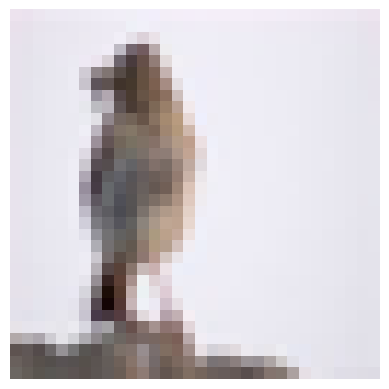

In [55]:
index = np.random.choice(range(len(x_test)))
predictions = np.argmax(model.predict(x_test[index].reshape((1, 32, 32, 3))), axis=-1)
predictions

LIB_DIR = "/home/eml/home/repository/git/oonisim/lib/code/python"
if LIB_DIR not in sys.path:
    sys.path.append(
        LIB_DIR    
    )
class_labels = np.array([
    'airplane', 
    'automobile', 
    'bird', 
    'cat', 
    'deer', 
    'dog', 
    'frog', 
    'horse', 
    'ship', 
    'truck'
])
from lib.util_opencv.image import (
    show_image,
)
image = x_test[index] * std + mean
show_image(image.astype(np.uint8), bgr_to_rgb=False)
print(f"{class_labels[y_test[index]]} prediction:[{class_labels[predictions[0]]}]")